Импортируем библиотеки, считываем данные

In [1]:
import plotly
import math
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
from timeit import default_timer as timer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from pandas.io.json import json_normalize
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')

In [2]:
import pickle
with open('results.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
tours = pd.read_pickle('tournaments.pkl')

Выбираем номера тестовых турниров и трейновых турниров в соответствии с годом

In [4]:
train_ids = []
for key, value in tours.items():
    if 'dateStart' in value and value['dateStart'][0:4] == '2019':
        train_ids.append(key)

In [5]:
test_ids = []
for key, value in tours.items():
    if 'dateStart' in value and value['dateStart'][0:4] == '2020':
        test_ids.append(key)

Составляем словарь для тестовых и трейновых турниров, куда входят все команды, если у них сущестует информация о
правильных/неправильных ответах:

In [6]:
train = defaultdict(list)
test = defaultdict(list)
total = defaultdict(list)
for key, i in data.items(): #номер игры
    if key in train_ids:
        for j in i: # команды
            if 'mask' in j and j['mask'] is not None :
                train[key].append(j)
                total[key].append(j)
    if key in test_ids:
        for j in i: # команды
            if 'mask' in j and j['mask'] is not None :
                test[key].append(j)
                total[key].append(j)

Посчитаем сколько команд принимает участие в каждом турнире (при необходимости, выводится список)

In [ ]:
cour = []
player_ids = defaultdict(list)
for key, value in train.items():
    teams = {}
    current = 0
    for team_members in value:
        for i in team_members:
            if i == 'teamMembers':
                if key in teams.keys():
                    teams[key] += 1
                    current  += 1
                else:
                    teams[key] = 1
                    current  += 1
    cour.append(current)
        
    

player_ids = []
for key, value in train.items():
    for team_members in value:
        for i in team_members:
    for i in value['teamMembers']:
        player_ids.append(i['player']['id'])
player_ids_games_amount = Counter(player_ids)

def split(word):
    return [char for char in word]
player_ids = []
player_game = defaultdict(list)
for key, value in train.items():
    for teams in value:
        for team in teams:
            if team == 'mask':
                result = teams[team]
            if team == 'teamMembers':
                for players in teams[team]:                
                    player_ids.append(players['player'])
                    player_game[key].append([players['player']['id'], result, len(result)])



Составим для трех выборок (трейн, тест, общий (тест + трейн)) список и два словаря. В списке ведется информация
об игроках (позже конвертируется в пандас), в словарях ведется информация по 1) каждому игроку, в каких турнирах принимал
участие, какие ответы дала его команда 2) каждой игре, играющих в ней игроках и ответы этих игроков

In [8]:
player_ids = []
game_player = defaultdict(list)
player_game = defaultdict(list)
for key, value in train.items():
    for teams in value:
        for team in teams:
            if team == 'mask':
                result = teams[team]
            if team == 'position':
                position = teams[team]
            if team == 'teamMembers':
                for players in teams[team]:
                    player_ids.append([players['player']['id'], players['player']['surname'], players['player']['name'], players['rating']])
                    game_player[key].append([players['player']['id'], result,len(result), position, players['rating']])
                    player_game[players['player']['id']].append([key, result, len(result), position, players['rating']])


In [9]:
player_ids_test = []
game_player_test = defaultdict(list)
player_game_test = defaultdict(list)
for key, value in test.items():
    for teams in value:
        for team in teams:
            if team == 'mask':
                result = teams[team]
            if team == 'position':
                position = teams[team]
            if team == 'teamMembers':
                for players in teams[team]:
                    player_ids_test.append([players['player']['id'], players['player']['surname'], players['player']['name'], players['rating']])
                    game_player_test[key].append([players['player']['id'], result,len(result), position, players['rating']])
                    player_game_test[players['player']['id']].append([key, result, len(result), position, players['rating']])


In [10]:
player_ids_total = []
game_player_total = defaultdict(list)
player_game_total = defaultdict(list)
for key, value in total.items():
    for teams in value:
        for team in teams:
            if team == 'mask':
                result = teams[team]
            if team == 'position':
                position = teams[team]
            if team == 'teamMembers':
                for players in teams[team]:
                    player_ids_total.append([players['player']['id'], players['player']['surname'], players['player']['name'], players['rating']])
                    game_player_total[key].append([players['player']['id'], result,len(result), position, players['rating']])
                    player_game_total[players['player']['id']].append([key, result, len(result), position, players['rating']])




Перебросим данные по участникам в Пандас, потом можно будет глянуть, какие игроки попали в ТОП-10.

In [11]:
details = pd.DataFrame(player_ids)
details_test = pd.DataFrame(player_ids_test)
details_total = pd.DataFrame(player_ids_total)

In [12]:
columns = ['id', 'surname', 'name', 'rating']
details.columns = columns
details_test.columns = columns

Поскольку участники ииграли больше одного раза, удалим дубликаты

In [13]:
details = details.drop_duplicates(subset='id', keep='last')
details = details.sort_values(by=['id'])
details_test = details_test.drop_duplicates(subset='id', keep='last')
details_test = details_test.sort_values(by=['id'])

2 method

In [14]:
vocab = {}

for key, value in player_game_total.items():
    count = 0
    for i in value:
        count += 1
    vocab[key] = count

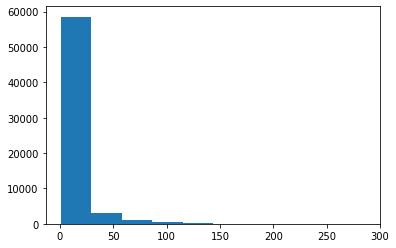

In [15]:
plt.hist(vocab.values(), bins=10)
plt.show()

In [16]:
d = dict((k, v) for k, v in vocab.items() if v >= 7)

In [17]:
vocab = d

In [18]:
len(vocab)

17563

In [19]:
cour = {}
player_ids = defaultdict(list)
for key, value in train.items():
    teams = {}
    current = 0
    for team_members in value:
        for i in team_members:
            if i == 'teamMembers':
                if key in teams.keys():
                    teams[key] += 1
                    current  += 1
                else:
                    teams[key] = 1
                    current  += 1
    cour[key] = current
        

In [20]:
def games_to_user(game):
    start = timer()
    team_amount = cour[game]
    inf = train[game]
    game_rows = np.full((team_amount, len(vocab)), np.zeros(len(vocab)))
    row_counter = 0
    for teams in inf:
        for team in teams:
            if team == 'teamMembers':
                for players in teams[team]:
                    if players['player']['id'] in vocab.keys():
                        game_rows[row_counter][vocab[players['player']['id']]] += 1
        row_counter += 1
    end = timer()
    return game_rows

In [21]:
total_game_mask = defaultdict(list)
for key, i in data.items(): #номер игры
    if key in train_ids:
        for j in i: # команды
            if 'mask' in j and j['mask'] is not None :
                total_game_mask[key].append(j['mask'])
    #if key in test_ids:
    #    for j in i: # команды
    #        if 'mask' in j and j['mask'] is not None :
    #            total_game_mask[key].append(j['mask'])

In [22]:
def pred(game):
    inf = total_game_mask[game]
    game_rows = np.full((len(inf), 1), 0.0)
    counter = 0
    for row in inf:
        sum_list_of_answers = 0.0
        count = 0.0
        for value in row:
            if value not in ["?", "X"]:
                sum_list_of_answers += int(value)
                count += 1
        game_rows[counter] = sum_list_of_answers / count
        counter += 1
    return game_rows

count = 0
train_ridge = {}
for i, value in train.items():
    count += 1
    if count % 4 == 0:
        train_ridge[i] = value
print(count)

count = 0
for i, value in train_ridge.items():
    for j in value:
        count += 1
print (count)

In [25]:
X_train_user = np.vstack(list(map(games_to_user, train.keys())))

In [26]:
y_train_user = np.vstack(list(map(pred, train.keys())))

In [27]:
start = timer()
model = LinearRegression()
y_train_user = np.clip(y_train_user, 1e-8, 1 - 1e-8)
inv_sig_y = np.log(y_train_user / (1 - y_train_user))  
model.fit(X_train_user, inv_sig_y)
end = timer()
print(end - start)

3344.7203913810004


In [29]:
def sigmoid(x):
    ex = np.exp(x)
    return ex / (1 + ex)

preds = sigmoid(model.predict(X_train_user))

In [30]:
diff = y_train_user - preds

In [31]:
res = model.coef_.reshape(-1, 1)

In [32]:
total = {}
for i, j in enumerate(vocab.keys()):
    total[j] = res[i]

In [33]:
for_pd = dict(Counter(total).most_common(10))

In [34]:
details[details['id'].isin(for_pd.keys())].sort_values(by='rating', ascending = False)

,id,surname,name,rating
439913,18332,Либер,Александр,14464
447681,1585,Архангельская,Юлия,13618
439823,110920,Дворянчиков,Алексей,13436
439821,47521,Декалов,Владислав,13113
443111,27009,Рождествин,Александр,11933
447934,54574,Карясов,Александр,11181
440101,20397,Мачевский,Александр,10984
440792,94673,Липодат,Борис,9967
188999,21374,Мозолевский,Михаил,9578
446928,64776,Попова,Александра,5734


In [36]:
cour_test = {}
player_ids = defaultdict(list)
for key, value in test.items():
    teams = {}
    current = 0
    for team_members in value:
        for i in team_members:
            if i == 'teamMembers':
                if key in teams.keys():
                    teams[key] += 1
                    current  += 1
                else:
                    teams[key] = 1
                    current  += 1
    cour_test[key] = current
def games_to_user(game):
    start = timer()
    team_amount = cour_test[game]
    inf = test[game]
    game_rows = np.full((team_amount, len(vocab)), np.zeros(len(vocab)))
    row_counter = 0
    team_position = np.full((team_amount, 1), 0)
    for teams in inf:
        for team in teams:
            if team == 'teamMembers':
                for players in teams[team]:
                    if players['player']['id'] in vocab.keys():
                        game_rows[row_counter][vocab[players['player']['id']]] += 1
        row_counter += 1
    end = timer()
    return game_rows
total_game_mask = defaultdict(list)
for key, i in data.items(): #номер игры
    #if key in train_ids:
    #    for j in i: # команды
    #        if 'mask' in j and j['mask'] is not None :
    #            total_game_mask[key].append(j['mask'])
    if key in test_ids:
        for j in i: # команды
            if 'mask' in j and j['mask'] is not None :
                total_game_mask[key].append(j['mask'])
def games_ranking(game):
    start = timer()
    team_amount = cour_test[game]
    inf = test[game]
    game_rows = np.full((team_amount, len(vocab)), np.zeros(len(vocab)))
    row_counter = 0
    team_position = np.full((team_amount, 1), 0)
    for teams in inf:
        for team in teams:
            if team == 'teamMembers':
                for players in teams[team]:
                    if players['player']['id'] in vocab.keys():
                        game_rows[row_counter][vocab[players['player']['id']]] += 1
            if team == 'position':
                team_position[row_counter] = teams[team]
                #print (teams[team])
        row_counter += 1
    end = timer()
    current_ranking = np.dot(game_rows, res)
    return current_ranking,  team_position
total_game_mask = defaultdict(list)
for key, i in data.items(): #номер игры
    #if key in train_ids:
    #    for j in i: # команды
    #        if 'mask' in j and j['mask'] is not None :
    #            total_game_mask[key].append(j['mask'])
    if key in test_ids:
        for j in i: # команды
            if 'mask' in j and j['mask'] is not None :
                total_game_mask[key].append(j['mask'])

In [37]:
total = 0
count = 0
for i in test.keys():
    ranking, actual_pos = np.vstack(list(map(games_ranking, [i])))
    spear_stst = stats.spearmanr(ranking, actual_pos)
    if math.isnan(spear_stst.correlation) == False:
        total += spear_stst.correlation
        count +=1
print (abs(total/count))

0.6033579289592746


In [38]:
total = 0
count = 0
for i in test.keys():
    ranking, actual_pos = np.vstack(list(map(games_ranking, [i])))
    kendall_stst = stats.kendalltau(ranking, actual_pos)
    if math.isnan(kendall_stst.correlation) == False:
        total += kendall_stst.correlation
        count +=1
print (abs(total/count))

0.4535306380641268


http://karlrosaen.com/ml/notebooks/em-coin-flips/

In [63]:

def coin_em(rolls, theta_A=None, theta_B=None, theta_C=None, theta_D=None,theta_E=None, theta_F=None, maxiter=10):
    theta_A = theta_A or random.random()
    theta_B = theta_B or random.random()
    theta_С = theta_A or random.random()
    theta_В = theta_B or random.random()
    theta_E = theta_B or random.random()
    theta_F = theta_B or random.random()
    thetas = [(theta_A, theta_B, theta_C, theta_D, theta_E, theta_E)]
    for c in range(maxiter):
        print("#%d:\t%0.2f %0.2f" % (c, theta_A, theta_B))
        heads_A, tails_A, heads_B, tails_B, heads_C, tails_C, heads_D, tails_D, heads_E, tails_E, heads_F, tails_F = e_step(rolls, theta_A, theta_B, theta_C, theta_D, theta_E, theta_F)
        theta_A, theta_B, theta_C, theta_D, theta_E, theta_F = m_step(heads_A, tails_A, heads_B, tails_B, heads_C, tails_C, heads_D, tails_D, heads_E, tails_E, heads_F, tails_F)
        
    thetas.append((theta_A, theta_B, theta_C, theta_D, theta_E, theta_E))    
    return theta_A, theta_B, theta_C, theta_D, theta_E, theta_E

def e_step(rolls, theta_A, theta_B, theta_C, theta_D, theta_E, theta_F):
    """Produce the expected value for heads_A, tails_A, heads_B, tails_B 
    over the rolls given the coin biases"""
    
    heads_A, tails_A = 0,0
    heads_B, tails_B = 0,0
    heads_C, tails_C = 0,0
    heads_D, tails_D = 0,0
    heads_E, tails_E = 0,0
    heads_F, tails_F = 0,0
    for trial in rolls:
        likelihood_A = coin_likelihood(trial, theta_A)
        likelihood_B = coin_likelihood(trial, theta_B)
        likelihood_C = coin_likelihood(trial, theta_C)
        likelihood_D = coin_likelihood(trial, theta_D)
        likelihood_E = coin_likelihood(trial, theta_E)
        likelihood_F = coin_likelihood(trial, theta_F)
        p_A = likelihood_A / (likelihood_A + likelihood_B + likelihood_B + likelihood_C + likelihood_D + likelihood_E + likelihood_F)
        p_B = likelihood_B / (likelihood_A + likelihood_B + likelihood_B + likelihood_C + likelihood_D + likelihood_E + likelihood_F)
        p_C = likelihood_C / (likelihood_A + likelihood_B + likelihood_B + likelihood_C + likelihood_D + likelihood_E + likelihood_F)
        p_D = likelihood_D / (likelihood_A + likelihood_B + likelihood_B + likelihood_C + likelihood_D + likelihood_E + likelihood_F)
        p_E = likelihood_E / (likelihood_A + likelihood_B + likelihood_B + likelihood_C + likelihood_D + likelihood_E + likelihood_F)
        p_F = likelihood_F / (likelihood_A + likelihood_B + likelihood_B + likelihood_C + likelihood_D + likelihood_E + likelihood_F)
        heads_A += p_A * trial.count("1")
        tails_A += p_A * trial.count("0")
        heads_B += p_B * trial.count("1")
        tails_B += p_B * trial.count("0")
        heads_C += p_C * trial.count("1")
        tails_C += p_C * trial.count("0")
        heads_D += p_D * trial.count("1")
        tails_D += p_D * trial.count("0") 
        heads_E += p_E * trial.count("1")
        tails_E += p_E * trial.count("0")
        heads_F += p_F * trial.count("1")
        tails_F += p_F * trial.count("0") 
    return heads_A, tails_A, heads_B, tails_B, heads_C, tails_C, heads_D, tails_D, heads_E, tails_E, heads_F, tails_F

def m_step(heads_A, tails_A, heads_B, tails_B, heads_C, tails_C, heads_D, tails_D, heads_E, tails_E, heads_F, tails_F):
    """Produce the values for theta that maximize the expected number of heads/tails"""

    # Replace dummy values with your implementation
    theta_A = heads_A / (heads_A + tails_A)
    theta_B = heads_B / (heads_B + tails_B)
    theta_C = heads_C / (heads_C + tails_C)
    theta_D = heads_D / (heads_D + tails_D)
    theta_E = heads_E / (heads_E + tails_E)
    theta_F = heads_F / (heads_F + tails_F)
    return theta_A, theta_B, theta_C, theta_D, theta_E, theta_F

def coin_likelihood(roll, bias):
    # P(X | Z, theta)
    numHeads = roll.count("1")
    flips = len(roll)
    return pow(bias, numHeads) * pow(1-bias, flips-numHeads)

In [64]:
rolls = [ "1", "0", "1", 
          "1", "0" ]
A, B, C, D, E, F = coin_em(rolls, 0.6, 0.5, 0.4, 0.3, 0.4, 0.5, maxiter=5)

#0:	0.60 0.50
#1:	0.72 0.63
#2:	0.72 0.63
#3:	0.72 0.63
#4:	0.72 0.63


In [170]:
X_test_user = np.vstack(list(map(games_to_user, test.keys())))

In [171]:
y_test_user = np.vstack(list(map(pred, test.keys())))

In [172]:
preds = sigmoid(model.predict(X_test_user))

In [173]:
vocab_test = {}

for key, value in player_game_test.items():
    count = 0
    for i in value:
        count += 1
    vocab_test[key] = count

In [174]:
d = dict((k, v) for k, v in vocab_test.items() if v >= 10)

In [175]:
vocab_test = d

In [187]:
len(vocab)

13178

In [188]:
total = {}
for i, j in enumerate(vocab.keys()):
    total[j] = res[i]

In [195]:
for_pd = dict(Counter(total).most_common(200))

In [193]:
dict(Counter(total).most_common(10))

{1585: array([2.7752488e+13]),
 26089: array([1.90097246e+13]),
 15456: array([6.31986737e+12]),
 18332: array([5.15682356e+12]),
 12313: array([3.55946426e+12]),
 17230: array([2.83179488e+12]),
 18036: array([5.0579343e+11]),
 96642: array([3.87535828e+11]),
 12747: array([1.94706071e+11]),
 31190: array([9.66355381e+10])}

In [196]:
details[details['id'].isin(for_pd.keys())].sort_values(by='rating', ascending = False)

,id,surname,name,rating
447403,30152,Сорожкин,Артём,14578
439913,18332,Либер,Александр,14464
442615,33620,Хаиткулов,Руслан,14151
447681,1585,Архангельская,Юлия,13618
442617,70750,Галиакберов,Денис,13615
...,...,...,...,...
449325,43686,Лурье,Эдуард,5295
443562,32767,Утикеев,Максимилиан,5236
443560,8159,Гриневич,Анна,5047
443564,67274,Вознесенская,Елена,4536


In [181]:
len(vocab_test.keys())

2850

In [19]:
a = 0
for i in game_player.values():
    a += len(i)
print (a)

451783


In [21]:
len(test_ids)

418

In [37]:
X_train = np.stack(list(map(predict, details['id'].sort_values())))

In [38]:
details['probability'] = X_train

In [39]:
details.head(1000)

,id,surname,name,rating,probability
423138,15,Абарников,Олег,7841,0.360714
404455,16,Абасалиев,Азер,3301,0.551282
3763,23,Абащенко,Андрей,791,0.500000
443177,31,Абасова,Ситара,5752,0.444444
444079,35,Абгарян,Нарек,6717,0.520607
...,...,...,...,...,...
274000,7002,Гиззатуллин,Рафаэль,0,0.556025
448063,7006,Гиззатуллина,Гульнара,9841,0.520579
439909,7008,Гилёв,Алексей,13998,0.745618
45630,7014,Гиленко,Дмитрий,0,0.457143


In [ ]:
vocab = {}
count = 0
for key, value in game_player.items():
    max_ln = 0
    for i in value:
        max_ln = max(max_ln, i[2])
    for ind in range(0, max_ln):
        vocab[str(key) + " " + str(ind)] = count
        count += 1
print (count)

In [ ]:
def user_to_bow(user_id):
    start = timer()
    user_row = np.zeros(len(vocab))
    inf = player_game[user_id]
    for row in inf:
        for i, value in enumerate(row[1]):
            if value not in ["?", "X"]:
                #print (i, value, len(row[1]), user_id, row[0])
                user_row[vocab[str(row[0]) + " " + str(i)]] += int(value)
    end = timer()
    #print(end - start)
    return user_row

In [575]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59101 entries, 56 to 451782
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       59101 non-null  int64 
 1   surname  59101 non-null  object
 2   name     59101 non-null  object
 3   rating   59101 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


In [579]:
y_train = total['rating'].values

In [581]:
X_train_tt, X_test_tt, y_train_val, y_test_val = train_test_split(
X_train, y_train, test_size=0.33, random_state=42)

In [ ]:
model = LogisticRegression()
model.fit(X_train_tt, y_train_val)

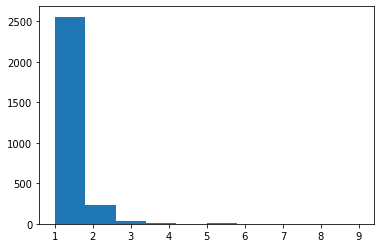

In [82]:
plt.hist(player_ids_games_amount.values())
plt.show()

train = defaultdict(list)
test = defaultdict(list)
for key, i in data.items(): #номер игры
    if key == a:
        print ('heu')
        for j in i: # команды
            print (j)
            if 'mask' in j:
                train[key].append(j)

APPENDIX.
Ниже представлена еще одна попытка построить вероятность ответа игрока правильно на вопрос через другие параметры,
такие как количество сыгранных игр, процент правильно отвеченных вопросов, рейтинг игрока и рейтинг (позиция) команды в сыгранной игре

In [39]:
def predict(user_id):
    inf = player_game[user_id]
    counter = 0
    list_of_answers = []
    user_answer = 0
    for row in inf:
        for i, value in enumerate(row[1]):
            if value not in ["?", "X"]:
                counter += 1
                user_answer += int(value)
                list_of_answers.append(int(value))
    return user_answer/counter

In [40]:
def predict_1(user_id):
    inf = player_game[user_id]
    counter = 0
    list_of_answers = []
    user_answer = 0
    game_counter = 0
    for row in inf:
        game_counter +=1
        for i, value in enumerate(row[1]):
            if value not in ["?", "X"]:
                counter += 1
                user_answer += int(value)
                list_of_answers.append(int(value))
    return game_counter, row[3], user_answer/counter, list_of_answers, row[4]

In [41]:
def predict_2(user_id):
    inf = player_game_test[user_id]
    counter = 0
    list_of_answers = []
    user_answer = 0
    game_counter = 0
    for row in inf:
        game_counter +=1
        for i, value in enumerate(row[1]):
            if value not in ["?", "X"]:
                counter += 1
                user_answer += int(value)
                list_of_answers.append(int(value))
    return game_counter, row[3], user_answer/counter, list_of_answers, row[4]

In [42]:
def cases_user_x(user_id):
    x_y_labels = predict_1(user_id)
    y_train = np.array(x_y_labels[3]).reshape(-1,1)
    x_train = np.full((len(y_train), 4), [x_y_labels[0],x_y_labels[1],x_y_labels[2], x_y_labels[4]])
    return x_train
def cases_user_y(user_id):
    x_y_labels = predict_1(user_id)
    y_train = np.array(x_y_labels[3]).reshape(-1,1)
    return y_train
def cases_user_x_1(user_id):
    x_y_labels = predict_1(user_id)
    y_train = np.mean(x_y_labels[3])
    x_train = np.full((1, 4), [x_y_labels[0],x_y_labels[1],x_y_labels[2], x_y_labels[4]])
    return x_train
def cases_user_y_1(user_id):
    x_y_labels = predict_1(user_id)
    y_train = np.mean(x_y_labels[3])
    return y_train
def cases_user_x_2(user_id):
    x_y_labels = predict_2(user_id)
    y_train = np.mean(x_y_labels[3])
    x_train = np.full((1, 4), [x_y_labels[0],x_y_labels[1],x_y_labels[2], x_y_labels[4]])
    return x_train
def cases_user_y_2(user_id):
    x_y_labels = predict_2(user_id)
    y_train = np.mean(x_y_labels[3])
    return y_train

In [43]:
X = np.vstack(list(map(cases_user_x_1, details['id'].sort_values())))
y = np.vstack(list(map(cases_user_y_1, details['id'].sort_values())))

In [44]:
X_test = np.vstack(list(map(cases_user_x_2, details_test['id'].sort_values())))
y_test = np.vstack(list(map(cases_user_y_2, details_test['id'].sort_values())))

In [47]:
scaler = StandardScaler()

In [48]:
X_norm = scaler.fit_transform(X)
X_norm_test = scaler.fit_transform(X_test)

In [49]:
start = timer()
model_0 = LinearRegression()
y = np.clip(y, 1e-8, 1 - 1e-8)
inv_sig_y = np.log(y / (1 - y))  
model_0.fit(X_norm, inv_sig_y)
end = timer()
print(end - start)

0.026735257000382262


In [67]:
def sigmoid(x):
    ex = np.exp(x)
    return ex / (1 + ex)

preds = sigmoid(model_0.predict(X_norm_test))

In [68]:
diff = y_test - preds

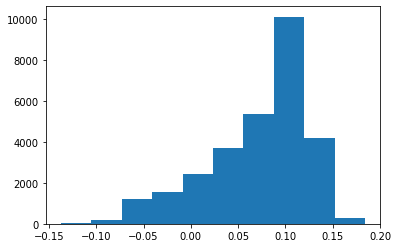

In [69]:
diff
plt.hist(diff)
plt.show()

In [76]:
details_test['res'] = preds

In [77]:
final = details_test.sort_values(['res'], ascending = False)
final.head(10)

,id,surname,name,rating,res
21619,36844,Щербина,Павел,855,0.951208
21625,51717,Джапаров,Ержан,2761,0.937103
21618,76264,Иваницкий,Илья,8125,0.934724
9513,224660,Байдуков,Валентин,0,0.932786
6696,108228,Резонтова,Наталья,286,0.932046
45348,32585,Улахович,Владимир,7590,0.923893
106480,73090,Третьяков,Кирилл,4675,0.919330
86969,169948,Павлов,Степан,75,0.915689
97218,201697,Бардин,Александр,1530,0.915094
4107,184250,Гудзь,Анна,1822,0.914087


результаты как-то не сильно вдохновили:)